In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

columns = ['coordinate_x','coordinate_y', 'displacement_x','displacement_y', 'load_x', 'load_y']

data =[[0,0,0,0,np.nan,np.nan],
       [20,0,np.nan,0,0,np.nan],
       [0,20,np.nan,np.nan,500,0]]

nodes = pd.DataFrame(data, columns = columns )

columns = ['start','end', 'area','material']

data = [[0,1, 2e-6,10e9],
        [1,2,2e-6,12e9],
        [2,0,3e-6,10e9]]

elements = pd.DataFrame(data, columns = columns)

print(nodes)

elements








   coordinate_x  coordinate_y  displacement_x  displacement_y  load_x  load_y
0             0             0             0.0             0.0     NaN     NaN
1            20             0             NaN             0.0     0.0     NaN
2             0            20             NaN             NaN   500.0     0.0


,start,end,area,material
0,0,1,0.000002,1.000000e+10
1,1,2,0.000002,1.200000e+10
2,2,0,0.000003,1.000000e+10


: 

In [66]:
def compute(element):
    
    start= element['start']
    end= element['end']
    
    
    coordinate_x_start = nodes.loc[start, 'coordinate_x']
    coordinate_x_end = nodes.loc[end, 'coordinate_x']
    
    coordinate_y_start = nodes.loc[start, 'coordinate_y']
    coordinate_y_end = nodes.loc[end, 'coordinate_y']
    
    deltaX = coordinate_x_end - coordinate_x_start
    deltaY = coordinate_y_end - coordinate_y_start
    length = np.sqrt(deltaX**2+deltaY**2)
    
    stiffness = element['area']*element['material']/ length
    
    c = deltaX/length
    s = deltaY/length
    
    
    
    
    Rotation = np.array([[c*c,c*s,-c*c,-c*s],
                 [c*s,s*s,-c*s,-s*s],
                 [-c*c,-c*s,c*c,c*s],
                 [-c*s,-s*s,c*s,s*s]])
    
    return length , stiffness, Rotation

elements[['length','stiffness','Rotation']] = elements.apply(compute, axis =1 , result_type='expand')
elements

,start,end,area,material,length,stiffness,Rotation
0,0,1,0.000002,1.000000e+10,20.000000,1000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0..."
1,1,2,0.000002,1.200000e+10,28.284271,848.528137,"[[0.4999999999999999, -0.4999999999999999, -0...."
2,2,0,0.000003,1.000000e+10,20.000000,1500.000000,"[[0.0, -0.0, -0.0, 0.0], [-0.0, 1.0, 0.0, -1.0..."


In [89]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices= indices.reshape(-1,2)
    K = np.zeros((N*2,N*2))
    start = element['start']
    end = element['end']
    indices= np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['stiffness']*element['Rotation']
    return K 

globalK = elements.apply(compute_globalK, axis = 1).sum()
globalK.round(1)

array([[ 1000. ,     0. , -1000. ,     0. ,     0. ,     0. ],
       [    0. ,  1500. ,     0. ,     0. ,     0. , -1500. ],
       [-1000. ,     0. ,  1424.3,  -424.3,  -424.3,   424.3],
       [    0. ,     0. ,  -424.3,   424.3,   424.3,  -424.3],
       [    0. ,     0. ,  -424.3,   424.3,   424.3,  -424.3],
       [    0. , -1500. ,   424.3,  -424.3,  -424.3,  1924.3]])

In [110]:
K = globalK

print(K)

def partition_K(K,A,B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB
    


U = nodes[['displacement_x','displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x','load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_K(K, A, B)
KAA


[[ 1000.             0.         -1000.             0.
      0.             0.        ]
 [    0.          1500.             0.             0.
      0.         -1500.        ]
 [-1000.             0.          1424.26406871  -424.26406871
   -424.26406871   424.26406871]
 [    0.             0.          -424.26406871   424.26406871
    424.26406871  -424.26406871]
 [    0.             0.          -424.26406871   424.26406871
    424.26406871  -424.26406871]
 [    0.         -1500.           424.26406871  -424.26406871
   -424.26406871  1924.26406871]]


array([[1424.26406871, -424.26406871,  424.26406871],
       [-424.26406871,  424.26406871, -424.26406871],
       [ 424.26406871, -424.26406871, 1924.26406871]])

In [126]:
#known displacement, UB

UB = U[B]
UB

PA  = P[A]
#known load, PA

PA
UA = np.dot(np.linalg.inv(KAA),(PA-np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA, UA) + np.dot(KBB, UB)

P[B]= PB

result = nodes.copy()

result [['displacement_x','displacement_y']]= U.reshape(-1,2)
result [['load_x','load_y']]=P.reshape(-1,2)

result

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000,0.000000,-500.0,-500.0
1,20,0,0.500000,0.000000,0.0,500.0
2,0,20,2.011845,0.333333,500.0,0.0


C:\Users\AlexP\AppData\Local\Temp\ipykernel_20000\2577512189.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(result['deformed_x'],result['deformed_y'], '--or', label='deformed', linewidth=5, color='blue')


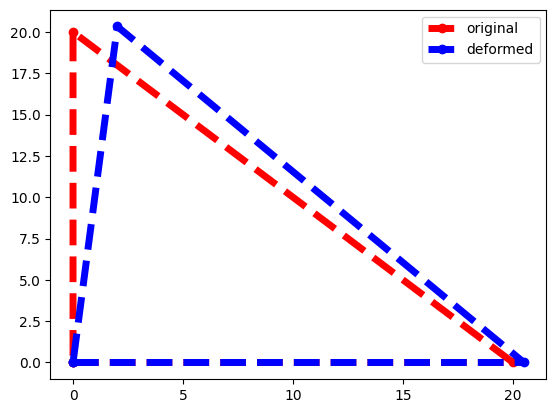

In [136]:
result['deformed_x'] = result['coordinate_x']+result['displacement_x']
result['deformed_y'] = result['coordinate_y']+result['displacement_y']


result.loc[3] = result.loc[0]
plt.plot(result['coordinate_x'],result['coordinate_y'], '--or', label='original', linewidth=5)
plt.plot(result['deformed_x'],result['deformed_y'], '--or', label='deformed', linewidth=5, color='blue')

plt.legend()